### Robotic path simulations

In [328]:
import pandas as pd
import sys
import numpy as np
import datetime
from io import StringIO
from typing import Optional, List
import tensorflow as tf
import math
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse


In [330]:
def load_data(bucket_name, object_key):
    df = pd.read_csv(datapath+object_key, index_col=0, parse_dates=True)
    return df

# loads data from s3 csv
def load_data_s3(bucket_name, object_key):
    client = boto3.client('s3')
    csv_obj = client.get_object(Bucket=bucket_name, Key=object_key)
    body = csv_obj['Body']
    csv_string = body.read().decode('utf-8')

    df = pd.read_csv(StringIO(csv_string), index_col=0, parse_dates=True)
    return df

def get_training_set(df, evaluation_date: str, training_interval_hours: int, sm_station_name: str, features: List[str]):

    df_subset = df.copy().loc[df.sm_station_name == sm_station_name]
    end_datetime = np.datetime64(evaluation_date + " 00:00:00") - 1 
    training_interval = np.timedelta64(training_interval_hours, 'h')
    start_datetime = (end_datetime) - (training_interval)
    df_subset = df_subset[str(start_datetime):str(end_datetime)]
    df_subset['t'] = range(0, df_subset.shape[0])
    cols_to_keep = ['t'] + features
    df_subset = df_subset.loc[:, cols_to_keep]
    return df_subset

def get_prediction_interval(df, evaluation_date: str, sm_station_name: str, target_column):
        
    df_subset = df.copy().loc[df.sm_station_name == sm_station_name]
    start_datetime = np.datetime64(evaluation_date + " 00:00:00") 
    end_datetime = start_datetime + np.timedelta64(23, 'h')
    df_subset = df_subset[str(start_datetime):str(end_datetime)]
    df_subset['t'] = range(0, df_subset.shape[0])
    df_subset = df_subset.loc[:, ['t'] + target_column]

    return df_subset
    
def create_train_test_sets(df, n_hrs, features, target):
    train_test_sets_by_sensor = {
        "sm_station_1": {}, 
        "sm_station_2": {}, 
        "sm_station_3": {}, 
        "sm_station_4": {}, 
        "sm_station_5": {},
        "sm_station_6": {} 
        }
    sm_station_names = df.sm_station_name.unique()
    eval_dates = np.unique(df[df.is_evaluation_period == True].index.date)
    for i in range(0, sm_station_names.shape[0]):
        station_keys = list(train_test_sets_by_sensor.keys())
        train_test_sets = {}
        for date in eval_dates:
            training_interval = get_training_set(df, str(date), training_interval_hours=n_hrs, sm_station_name = sm_station_names[i], features=features)
            prediction_interval = get_prediction_interval(df, str(date), sm_station_name = sm_station_names[i], target_column=target)
            train_test_sets[f"{str(date)}"] = {"train_set": training_interval, 
                                             "test_set": prediction_interval}
    
        train_test_sets_by_sensor[station_keys[i]] = train_test_sets
    return train_test_sets_by_sensor
    
def plot_series(time, series, format="-", start=0, end=None, title=None, label=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

        for series_num in series:
            # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Soil Moisture")
    
    # Label the title
    plt.title(title)
    
    plt.legend(label)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()
    
def calculate_diff(train, test):
    # calculate change in soil moisture as sm_diff
    train['sm_diff'] = train.sm_soil_moisture.diff()
    test['sm_diff'] = test.sm_soil_moisture.diff()
    test.sm_diff.iloc[0] = test.sm_soil_moisture.iloc[0] - train.sm_soil_moisture.iloc[-1]
    return train, test


def create_train_test(train, test, features=None):
    if type(features) is tuple:
        x_train = pd.DataFrame()
        x_test = pd.DataFrame()
        for i in features:
            x_train[i] = train[i][1:]
            x_test[i] = test[i]   
    else:
        x_train = train.bom_actual_precipitation_hourly[1:]
        x_test = test.bom_actual_precipitation_hourly

    y_train = train.sm_diff[1:]
    y_test = test.sm_diff
    
    x_train = x_train.fillna(method='ffill').to_numpy()
    y_train = y_train.fillna(method='ffill').to_numpy()

    x_test = x_test.fillna(method='ffill').to_numpy()
    y_test = y_test.fillna(method='ffill').to_numpy()

    return x_train, y_train, x_test, y_test


def get_best_k(x_train, y_train): 
    mae_val = [] #to store rmse values for different k
    for K in range(20):
        K = K+1
        model = neighbors.KNeighborsRegressor(n_neighbors = K) #, weights='distance')

        model.fit(x_train[:-24], y_train[:-24])  #fit the model
        pred=model.predict(x_train[-24:]) #make prediction on test set
        error = tf.keras.metrics.mean_absolute_error(y_train[-24:], pred).numpy()
        mae_val.append(error) #store rmse values
    min_mae = min(mae_val)   
    best_k = mae_val.index(min_mae)+1

    return best_k

# calculates final predicted sm values by adding predicted diff to the last training value
def calc_final_pred(pred_diff, last_sm):
    final_pred = []
    for diff in pred_diff:
        current_sm = last_sm + diff
        last_sm = current_sm
        final_pred.append(current_sm)
    return final_pred

def run_knn(train, test, features): 
    # std_scaler= StandardScaler()
    train, test = calculate_diff(train, test)
    
    # create train and test sets using specified features
    x_train, y_train, x_test, y_test = create_train_test(train, test,features)
    # # scale values across diff features
    # x_train = std_scaler.fit_transform(x_train)
    # x_test = std_scaler.fit_transform(x_test)
    
    # get best k neighbours
    best_k = get_best_k(x_train, y_train) 

    model = neighbors.KNeighborsRegressor(n_neighbors = best_k) #, weights='distance')
    model.fit(x_train, y_train)  #fit the model
    pred_diff=model.predict(x_test) #make prediction on test set

    last_sm = train.sm_soil_moisture[-1]
    final_pred = calc_final_pred(pred_diff, last_sm)
    mae = tf.keras.metrics.mean_absolute_error(test.sm_soil_moisture, final_pred).numpy()
    mse = rmse(test.sm_soil_moisture.to_numpy(), final_pred)
    # mse = tf.keras.metrics.mean_squared_error(test.sm_soil_moisture, final_pred).numpy()
    return final_pred, mae, mse

In [332]:

df = load_data('simpact_combined_for_eval','simpact_combined_for_eval.csv')
#df = df.fillna(method='ffill')



In [334]:
def generate_station_names(sensor_numbers):
    station_names = ['SENS' + str(sensor_number).zfill(4) + '-SM-SOPA' for sensor_number in sensor_numbers]
    return station_names

def filter_df_by_station_names(df, station_names):
    filtered_df = df[df['sm_station_name'].isin(station_names)]
    return filtered_df

In [335]:
# Example usage:
#sensor_numbers = [63,39,125,37,96,76]  # Linear path - Path 1
sensor_numbers = [146,148,155,126,24,43]  # Circular path - Path 2
station_names = generate_station_names(sensor_numbers)
station_names

['SENS0146-SM-SOPA',
 'SENS0148-SM-SOPA',
 'SENS0155-SM-SOPA',
 'SENS0126-SM-SOPA',
 'SENS0024-SM-SOPA',
 'SENS0043-SM-SOPA']

In [337]:
# Example usage:
df = filter_df_by_station_names(df, station_names)




In [339]:
#dfc = load_data('simpact-combined-dataset','simpact_combined_dataset.csv')
# df = df.fillna(method='ffill')

#dfc["vpd"] = (0.6108 * np.exp((17.27 * df.bom_actual_temperature)/(df.bom_actual_temperature + 237.3))) * (1.0 - (df.bom_actual_relative_humidity / 100.0))
# specify variables 

In [340]:
import pandas as pd

# Assuming df is your DataFrame with datetime index
df['Hour'] = df.index.hour


In [342]:
dfback=df.copy()

In [343]:
#skip this

In [345]:
#df = load_data('simpact-combined-dataset','simpact_combined_dataset.csv')
###### from train_test_set_create...

unique_dates =  np.unique(df.index.date)
last_index =  unique_dates.shape[0] -2
mid_point = last_index / 2 
mid_point_index = int(mid_point -1)

start_date = np.unique(df.index.date)[mid_point_index]
end_date = np.unique(df.index.date)[-2] 


interval = round((end_date - start_date).days / 4) # get the interval that should be between each evaluation point (we want evaluation points that are evenly spaced)
eval_date_indices = [mid_point_index, mid_point_index+(interval), mid_point_index+(interval*2), mid_point_index+(interval*3), last_index]


eval_dates = unique_dates[eval_date_indices]

In [346]:
print(eval_dates)

[datetime.date(2022, 7, 28) datetime.date(2022, 8, 17)
 datetime.date(2022, 9, 6) datetime.date(2022, 9, 26)
 datetime.date(2022, 10, 17)]


In [347]:
for date in eval_dates:
    print(f"- {date.strftime('%Y-%m-%d')}")

- 2022-07-28
- 2022-08-17
- 2022-09-06
- 2022-09-26
- 2022-10-17


In [348]:


# UPDATE November 20 2022: we need additional days with precipitation. We will manually select two types of conditions: one where there is a long dry period, followed by rain
# and another day of rain where there is rainfall without a dry spell beforehand 
manual_dates = [np.datetime64("2022-07-02"), np.datetime64("2022-07-22")]
eval_dates = np.append(eval_dates,manual_dates)

df['is_evaluation_period'] = False

for eval_date in eval_dates:
     df.loc[(df.index.get_level_values('datetime').date == eval_date),'is_evaluation_period'] = True
######
df["vpd"] = (0.6108 * np.exp((17.27 * df.bom_actual_temperature)/(df.bom_actual_temperature + 237.3))) * (1.0 - (df.bom_actual_relative_humidity / 100.0))


In [349]:
import pandas as pd

def process_sensor_data(df, sm_station_names):
    for i, station_name in enumerate(sm_station_names):
        is_odd_sensor = i % 2 == 1
        station_data = df[df['sm_station_name'] == station_name]
        if is_odd_sensor:
            hours_to_process = [hour for hour in range(0, 22, 2)]
        else:
            hours_to_process = [hour for hour in range(1, 23, 2)]
        for hour in hours_to_process:
            if hour == 0:
                #before = station_data[station_data.index.hour == 23]
                before = station_data[station_data.index.hour == 1]
                after = station_data[station_data.index.hour == 1]
            elif hour == 23:
                before = station_data[station_data.index.hour == 22]
                #after = station_data[station_data.index.hour == 0]
                after = station_data[station_data.index.hour == 22]
            else:
                before = station_data[station_data.index.hour == hour - 1]
                after = station_data[station_data.index.hour == hour + 1]
            for column in ['sm_soil_temperature', 'sm_soil_moisture', 'vpd']:
                df.loc[(df.index.hour == hour) & (df['sm_station_name'] == station_name), column] = (before[column].values[0] + after[column].values[0]) / 2
    return df

# Example usage:
# Assuming df is your DataFrame and sm_station_names is your list of station names
# df = process_sensor_data(df, sm_station_names)


In [350]:
df = process_sensor_data(df, station_names)


In [351]:
# specify variables 
# features = ['sm_soil_moisture', 'bom_forecasted_temperature', 'bom_forecasted_relative_humidity', 'bom_forecasted_precipitation_quantitiy']
# target = ['sm_soil_moisture', 'bom_forecasted_temperature', 'bom_forecasted_relative_humidity', 'bom_forecasted_precipitation_quantitiy']
data_features = ['sm_soil_moisture', 'bom_actual_precipitation_hourly', 'bom_actual_temperature', 'bom_actual_relative_humidity', 'vpd'] # features to include in training set
target = ['sm_soil_moisture', 'bom_actual_precipitation_hourly', 'bom_actual_temperature', 'bom_actual_relative_humidity', 'vpd'] # the column with the variable we want to predict
n_hrs = 400 # the training interval in hours

# run the function 
train_test_sets_by_sensor = create_train_test_sets(df, n_hrs, data_features, target)

In [353]:
df['sm_station_name'].unique()

array(['SENS0126-SM-SOPA', 'SENS0148-SM-SOPA', 'SENS0155-SM-SOPA',
       'SENS0024-SM-SOPA', 'SENS0043-SM-SOPA', 'SENS0146-SM-SOPA'],
      dtype=object)

In [354]:
def count_records_per_sensor(df):
    # Convert the index to datetime if it's not already
    df.index = pd.to_datetime(df.index)
    
    # Group by sm_station_name and date, then calculate counts
    counts_per_sensor = df.groupby(['sm_station_name', df.index.date]).size().reset_index(name='records')
    
    # Aggregate to count unique hours per sensor
    unique_hours_per_sensor = df.groupby('sm_station_name').size().reset_index(name='hours')
    
    # Merge to combine counts and sort by number of records
    result = pd.merge(counts_per_sensor.groupby('sm_station_name').size().reset_index(name='records'), unique_hours_per_sensor, on='sm_station_name')
    result = result.sort_values(by='records', ascending=False)
    
    return result

# Example usage:
counts_per_sensor = count_records_per_sensor(df)
for index, row in counts_per_sensor.iterrows():
    print(f"Sensor: {row['sm_station_name']}, Number of Hours: {row['hours']}, Number of Records: {row['records']}")


Sensor: SENS0024-SM-SOPA, Number of Hours: 3865, Number of Records: 162
Sensor: SENS0043-SM-SOPA, Number of Hours: 3865, Number of Records: 162
Sensor: SENS0126-SM-SOPA, Number of Hours: 3865, Number of Records: 162
Sensor: SENS0146-SM-SOPA, Number of Hours: 3865, Number of Records: 162
Sensor: SENS0148-SM-SOPA, Number of Hours: 3865, Number of Records: 162
Sensor: SENS0155-SM-SOPA, Number of Hours: 3865, Number of Records: 162


In [126]:
print(eval_dates)

[datetime.date(2022, 7, 28) datetime.date(2022, 8, 17)
 datetime.date(2022, 9, 6) datetime.date(2022, 9, 26)
 datetime.date(2022, 10, 17) datetime.date(2022, 7, 2)
 datetime.date(2022, 7, 22)]


In [127]:
print(df.index.min(),df.index.max())

2022-05-10 00:00:00+00:00 2022-10-18 00:00:00+00:00


In [128]:
#dfc = load_data('simpact-combined-dataset','simpact_combined_dataset.csv')
#dfc = load_data('simpact_combined_for_eval','simpact_combined_for_eval.csv')
#dfc = dfc.fillna(method='ffill')

In [355]:
data_features = ['sm_soil_moisture', 'bom_actual_precipitation_hourly', 'bom_actual_temperature', 'bom_actual_relative_humidity', 'vpd'] # features to include in training set
target = ['sm_soil_moisture', 'bom_actual_precipitation_hourly', 'bom_actual_temperature', 'bom_actual_relative_humidity', 'vpd'] # the column with the variable we want to predict
n_hrs = 400 # the training interval in hours

# run the function 
train_test_sets_by_sensor = create_train_test_sets(df, n_hrs, data_features, target)

In [356]:
# sensor_list = ['sm_station_1', 'sm_station_2', 'sm_station_3', 'sm_station_4', 'sm_station_5']
# dates = ['2022-07-02', '2022-07-22', '2022-07-28', '2022-08-17', '2022-09-06', '2022-09-26', '2022-10-17']

sensor_list = list(train_test_sets_by_sensor.keys())
dates = list(train_test_sets_by_sensor[sensor_list[0]].keys())


## KNN

In [ ]:
results = {'sensor':[], 'date':[], 'mae':[]}
# features = ('bom_forecasted_temperature', 'bom_forecasted_relative_humidity', 'bom_forecasted_precipitation_quantitiy')

train_features = ('bom_actual_precipitation_hourly', 'vpd') #'bom_actual_temperature', 'bom_actual_relative_humidity') #, 'sm_soil_moisture')
mae_list = []
mse_list = []
sensor_date_list=[]
nomae_list = []
#mae_df = pd.DataFrame(columns=['sensor', 'date', 'mae'])
#mae_df = mae_df.append({'sensor': 'sm_station_1', 'date': '2022-07-02', 'mae': 1}, ignore_index=True)


for sensor in sensor_list:
    # fig, ax = plt.subplots(5, sharex='col', sharey='row', figsize=(15,15))
    i = 0
    for date in dates:
        # adding break to skipp empty set
        # if sensor =='sm_station_4' and (date == '2022-10-17' or date == '2022-07-28'):
        #     break
        results['sensor'].append(sensor)
        results['date'].append(date)
        
        train = train_test_sets_by_sensor[sensor][date]['train_set']
        train = train.fillna(method='ffill')

        test = train_test_sets_by_sensor[sensor][date]['test_set']
        test = test.fillna(method='ffill')
        
        try:
            final_pred, mae, mse = run_knn(train, test, train_features)
            mae_list.append(mae)
            mse_list.append(mse)
            results['mae'].append(mae)
            #mae_df = mae_df.append({'sensor': sensor, 'date': date, 'mae': mae}, ignore_index=True)

            # results['mae'].append(mae)
            plot_series(test.t, (test.sm_soil_moisture, final_pred), title = sensor + ' ' + date, label = ('ground truth', 'forecast'))
            # plot_series(test.t, (test.bom_actual_precipitation_hourly, test.bom_actual_temperature, test.bom_actual_relative_humidity), label = features)

        except:
            nomae_list.append([sensor,date])
            #mae_df = mae_df.append({'sensor': sensor, 'date': date, 'mae': 0.001}, ignore_index=True)
            results['mae'].append(-0.0001)

            pass
        


In [ ]:
resultall = pd.merge(merged_df, resultdf_cir, on=['sensor', 'date'], how='left')


In [363]:
resultall = resultall.rename(columns={'mae_x': 'Base'})


In [364]:
resultall = resultall.rename(columns={'mae_y': 'Linear'})


In [365]:
resultall = resultall.rename(columns={'mae': 'Circular'})


In [366]:
resultall

,sensor,date,Base,Linear,Circular
0,sm_station_1,2022-07-02,1.888346,1.605866,-0.000100
1,sm_station_1,2022-07-22,1.148492,0.245665,-0.000100
2,sm_station_1,2022-07-28,0.207010,0.415048,-0.000100
3,sm_station_1,2022-08-17,0.053368,0.424731,-0.000100
4,sm_station_1,2022-09-06,0.161242,0.180058,-0.000100
5,sm_station_1,2022-09-26,0.213439,0.419864,-0.000100
6,sm_station_1,2022-10-17,1.037428,0.263841,-0.000100
7,sm_station_2,2022-07-02,2.252989,-0.000100,-0.000100
8,sm_station_2,2022-07-22,0.671526,-0.000100,-0.000100
9,sm_station_2,2022-07-28,1.071232,-0.000100,-0.000100


In [367]:
resultall.to_csv('rob_mae_all.csv', index=False)

In [369]:
filtered_lin = resultall[['sensor', 'date', 'Base', 'Linear']][(resultall['Linear'] > 0) & (resultall['Base'] > 0)]
filtered_lin

,sensor,date,Base,Linear
0,sm_station_1,2022-07-02,1.888346,1.605866
1,sm_station_1,2022-07-22,1.148492,0.245665
2,sm_station_1,2022-07-28,0.207010,0.415048
3,sm_station_1,2022-08-17,0.053368,0.424731
4,sm_station_1,2022-09-06,0.161242,0.180058
5,sm_station_1,2022-09-26,0.213439,0.419864
6,sm_station_1,2022-10-17,1.037428,0.263841
21,sm_station_4,2022-07-02,11.275028,6.420408
23,sm_station_4,2022-07-28,0.168813,0.236536
24,sm_station_4,2022-08-17,0.140234,0.250449


In [374]:
filtered_lin = resultall[['sensor', 'date', 'Base', 'Linear']][(resultall['Linear'] > 0) & (resultall['Base'] > 0)&(resultall['Base'] < 6)]
filtered_lin

,sensor,date,Base,Linear
0,sm_station_1,2022-07-02,1.888346,1.605866
1,sm_station_1,2022-07-22,1.148492,0.245665
2,sm_station_1,2022-07-28,0.207010,0.415048
3,sm_station_1,2022-08-17,0.053368,0.424731
4,sm_station_1,2022-09-06,0.161242,0.180058
5,sm_station_1,2022-09-26,0.213439,0.419864
6,sm_station_1,2022-10-17,1.037428,0.263841
23,sm_station_4,2022-07-28,0.168813,0.236536
24,sm_station_4,2022-08-17,0.140234,0.250449
25,sm_station_4,2022-09-06,0.047037,1.156183


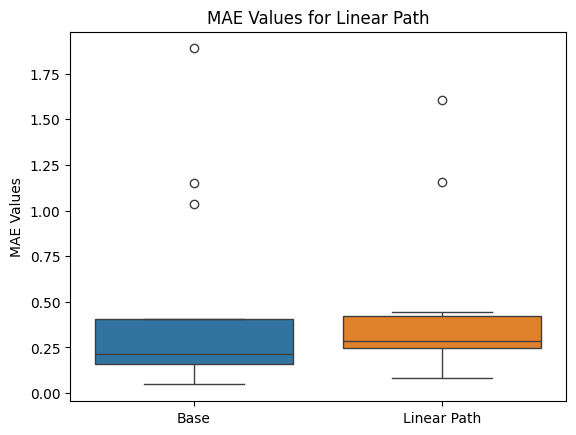

In [375]:
import seaborn as sns
data_to_plot = pd.concat([filtered_lin['Base'], filtered_lin['Linear']], axis=1, keys=['Base', 'Linear Path'])

# Create the boxplot
sns.boxplot(data=data_to_plot)

# Add labels to the axes and a title
plt.xlabel('')
plt.ylabel('MAE Values')
plt.title('MAE Values for Linear Path')

# Show the plot
plt.show()

In [376]:
filtered_cir = resultall[['sensor', 'date', 'Base', 'Circular']][(resultall['Circular'] > 0) & (resultall['Base'] > 0) &(resultall['Base'] < 6)]
filtered_cir

,sensor,date,Base,Circular
14,sm_station_3,2022-07-02,0.885450,0.839544
15,sm_station_3,2022-07-22,0.279970,0.215995
16,sm_station_3,2022-07-28,0.192019,0.437725
17,sm_station_3,2022-08-17,0.322137,0.242460
18,sm_station_3,2022-09-06,0.123817,0.090440
19,sm_station_3,2022-09-26,0.287711,0.172512
20,sm_station_3,2022-10-17,0.097440,0.175459
22,sm_station_4,2022-07-22,0.843518,0.604059
23,sm_station_4,2022-07-28,0.168813,0.234573
24,sm_station_4,2022-08-17,0.140234,0.153776


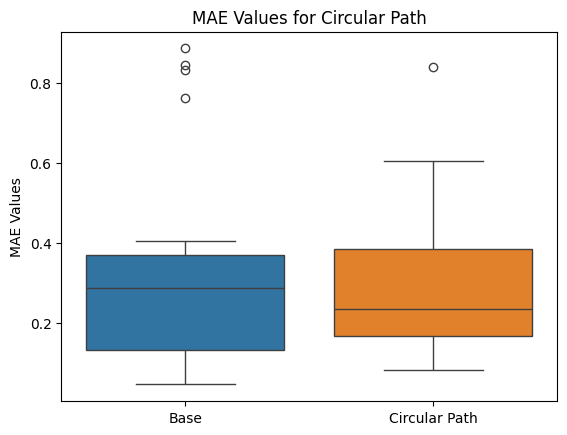

In [377]:
import seaborn as sns
data_to_plot = pd.concat([filtered_cir['Base'], filtered_cir['Circular']], axis=1, keys=['Base', 'Circular Path'])

# Create the boxplot
sns.boxplot(data=data_to_plot)

# Add labels to the axes and a title
plt.xlabel('')
plt.ylabel('MAE Values')
plt.title('MAE Values for Circular Path')

# Show the plot
plt.show()

In [248]:
mae_list = [x for x in mae_list if not math.isnan(x)]


In [250]:
pd.DataFrame(mae_list).describe()

,0
count,20.000000
mean,0.814970
std,2.337485
min,0.083542
25%,0.170453
50%,0.238516
75%,0.437337
max,10.711717


In [251]:
results_dict = {'RMSE': mse_list, 'MAE': mae_list}
pd.DataFrame(results_dict).describe()

,RMSE,MAE
count,20.000000,20.000000
mean,0.866290,0.814970
std,2.397567,2.337485
min,0.101280,0.083542
25%,0.186768,0.170453
50%,0.257331,0.238516
75%,0.484427,0.437337
max,11.012418,10.711717


In [138]:
#maerob=pd.DataFrame(mae_list)

In [212]:
maerob['Circular']=pd.DataFrame(mae_list)
maerob

,0,Linear,Circular
0,1.939795,1.605866,0.839544
1,0.459564,0.245665,0.215995
2,0.241649,0.415048,0.437725
3,0.377967,0.424731,0.242460
4,0.184544,0.180058,0.090440
5,0.458233,0.419864,0.172512
6,0.092849,0.263841,0.175459
7,9.072214,6.420408,10.711717
8,1.067838,0.236536,0.604059
9,0.400203,0.250449,0.234573


In [221]:
maerob = maerob.rename(columns={0: 'base'})
maerob.columns

Index(['base', 'Linear', 'Circular'], dtype='object')

In [230]:
maerob.iloc[14,0]=12
maerob.iloc[21,0]=13


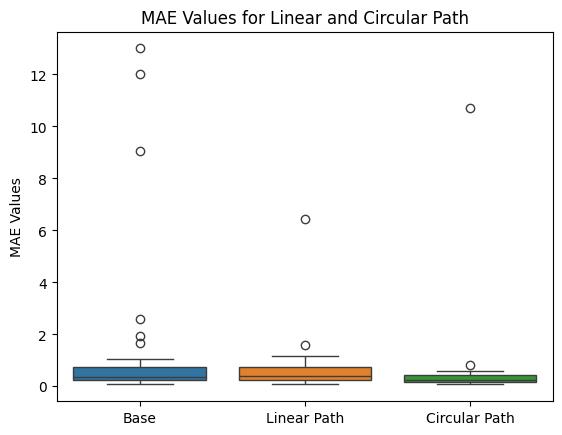

In [241]:
import seaborn as sns
data_to_plot = pd.concat([maerob['base'], maerob['Linear'], maerob['Circular']], axis=1, keys=['Base', 'Linear Path', 'Circular Path'])

# Create the boxplot
sns.boxplot(data=data_to_plot)

# Add labels to the axes and a title
plt.xlabel('')
plt.ylabel('MAE Values')
plt.title('MAE Values for Linear and Circular Path')

# Show the plot
plt.show()

In [ ]:
#prepare dfc - don't run as already done and csv created
df=dfc.copy()
unique_dates =  np.unique(df.index.date)
last_index =  unique_dates.shape[0] -2
mid_point = last_index / 2 
mid_point_index = int(mid_point -1)

start_date = np.unique(df.index.date)[mid_point_index]
end_date = np.unique(df.index.date)[-2] 


interval = round((end_date - start_date).days / 4) # get the interval that should be between each evaluation point (we want evaluation points that are evenly spaced)
eval_date_indices = [mid_point_index, mid_point_index+(interval), mid_point_index+(interval*2), mid_point_index+(interval*3), last_index]


eval_dates = unique_dates[eval_date_indices]

# UPDATE November 20 2022: we need additional days with precipitation. We will manually select two types of conditions: one where there is a long dry period, followed by rain
# and another day of rain where there is rainfall without a dry spell beforehand 
manual_dates = [np.datetime64("2022-07-02"), np.datetime64("2022-07-22")]
eval_dates = np.append(eval_dates,manual_dates)

df['is_evaluation_period'] = False

for eval_date in eval_dates:
     df.loc[(df.index.get_level_values('datetime').date == eval_date),'is_evaluation_period'] = True
######
df["vpd"] = (0.6108 * np.exp((17.27 * df.bom_actual_temperature)/(df.bom_actual_temperature + 237.3))) * (1.0 - (df.bom_actual_relative_humidity / 100.0))
# specify variables 

In [ ]:
df.to_csv(datapath+'simpact_combined_for_eval.csv')

In [12]:
import re

def extract_sensor_number(station_name):
    # Use regular expression to extract sensor number
    match = re.search(r'SENS(\d+)', station_name)
    if match:
        sensor_number = match.group(1)
        return sensor_number
    else:
        return None

def extract_station_locations(df):
    # Group by station name and take the first latitude and longitude for each station
    dfloc = df.groupby('sm_station_name').agg(
        sm_latitude=('sm_latitude', 'first'),
        sm_longitude=('sm_longitude', 'first')
    ).reset_index()
    
    # Extract sensor number from station name
    dfloc['sensor_number'] = dfloc['sm_station_name'].apply(extract_sensor_number)
    
    return dfloc

# Example usage:
dfloc = extract_station_locations(df)
print(dfloc)


      sm_station_name  sm_latitude  sm_longitude sensor_number
0    SENS0002-SM-SOPA    -33.84721     151.07588          0002
1    SENS0006-SM-SOPA    -33.84698     151.07597          0006
2    SENS0008-SM-SOPA    -33.84684     151.08209          0008
3    SENS0010-SM-SOPA    -33.84641     151.08150          0010
4    SENS0012-SM-SOPA    -33.84667     151.08134          0012
..                ...          ...           ...           ...
129  SENS0204-SM-SOPA    -33.85233     151.07694          0204
130  SENS0206-SM-SOPA    -33.85142     151.07849          0206
131  SENS0207-SM-SOPA    -33.84908     151.07653          0207
132  SENS0209-SM-SOPA    -33.85221     151.07844          0209
133  SENS0210-SM-SOPA    -33.85163     151.07866          0210

[134 rows x 4 columns]


In [20]:
import folium
from IPython.display import display

def plot_sensor_locations(df_unique, sensor_numbers):
    
    #sensor_numbers = [63,39,125,37,96,76]  # Linear path - Path 1
    station_names = generate_station_names(sensor_numbers)
    # Filter dataframe to include only sensors from the provided list
    df_filtered = df_unique[df_unique['sm_station_name'].isin(station_names)]
    
    # Create a map with initial centering and zoom level based on all sensor locations
    map_sensor_locations = folium.Map(location=[df_filtered['sm_latitude'].mean(), df_filtered['sm_longitude'].mean()], zoom_start=10)
    
    # Add markers for each sensor location with sensor number as label
    for index, row in df_filtered.iterrows():
        folium.Marker([row['sm_latitude'], row['sm_longitude']], popup=row['sm_station_name'], 
                      tooltip=row['sensor_number']).add_to(map_sensor_locations)
        # Define custom HTML for the marker
        html = f"<div style='font-weight: bold;'>Sensor {row['sensor_number']}</div>"
        # Add marker with custom HTML as a permanent label
        folium.Marker([row['sm_latitude'], row['sm_longitude']], popup=row['sm_station_name'], icon=folium.DivIcon(html=html)).add_to(map_sensor_locations)
    
    
    # Display the map directly in the Jupyter Notebook
    display(map_sensor_locations)


# Example usage:
# Assuming df_unique is your dataframe and sensor_list is a list of sensors
# Replace ['SENS0020-SM-SOPA', 'SENS0107-SM-SOPA', 'SENS0152-SM-SOPA'] with your actual list of sensors
#sensor_list = ['SENS0020-SM-SOPA', 'SENS0028-SM-SOPA', 'SENS0063-SM-SOPA', 'SENS0066-SM-SOPA']

#sensor_list = ['SENS0107-SM-SOPA', 'SENS0016-SM-SOPA', 'SENS0114-SM-SOPA', 'SENS0125-SM-SOPA', 'SENS0126-SM-SOPA']
#sensor_list=df['sm_station_name'].unique()
sensor_list=[98,20,28,63,66]

plot_sensor_locations(dfloc, sensor_list, target_sensor)


In [28]:
generate_station_names([98])

['SENS0098-SM-SOPA']

In [34]:
str(98).zfill(4)

'0098'

In [66]:
import folium
from IPython.display import display

def plot_sensor_locations(df_unique, sensor_numbers, target_sensor):
    
    # Generate station names from sensor numbers
    station_names = generate_station_names(sensor_numbers)
    # Filter dataframe to include only sensors from the provided list
    df_filtered = df_unique[df_unique['sm_station_name'].isin(station_names)]
    
    # Create a map with initial centering and zoom level based on all sensor locations
    map_sensor_locations = folium.Map(location=[df_filtered['sm_latitude'].mean(), df_filtered['sm_longitude'].mean()], zoom_start=10,height='800px')
    
   
    
    for index, row in df_filtered.iterrows():
        if row['sensor_number'] == str(target_sensor).zfill(4):
            # Red marker and text for the target sensor
            folium.Marker([row['sm_latitude'], row['sm_longitude']], popup=row['sm_station_name'],
                          tooltip=row['sensor_number'], icon=folium.Icon(color='red')).add_to(map_sensor_locations)
            # Define custom HTML for the marker with red text and larger font
            html = f"<div style='font-weight: bold; color: red; font-size: 16px;'>Sensor {row['sensor_number']}</div>"
            folium.Marker([row['sm_latitude'], row['sm_longitude']], popup=row['sm_station_name'], 
                          icon=folium.DivIcon(html=html)).add_to(map_sensor_locations)
        else:
            # Default marker and text for other sensors
            folium.Marker([row['sm_latitude'], row['sm_longitude']], popup=row['sm_station_name'], 
                          tooltip=row['sensor_number']).add_to(map_sensor_locations)
            # Define custom HTML for the marker with larger font
            html = f"<div style='font-weight: bold; font-size: 9px;'>Sensor {row['sensor_number']}</div>"
            folium.Marker([row['sm_latitude'], row['sm_longitude']], popup=row['sm_station_name'], 
                          icon=folium.DivIcon(html=html)).add_to(map_sensor_locations)
    
    display(map_sensor_locations)
    
def as_list(x):
    if type(x) is list:
        return x
    else:
        return [x]

#target = 98
#k-shape
#sensor_list=[20,28,63,66,98]

#dtw
#sensor_list=[17,19,73,118,119,134,137,185,192,203,220,98]

target=100
# from cluster 19 of k-shape k=17 for sensor 107
#sensor_list=[14,19,24,42,150,209,226,229,230,107]

#dtw
#sensor_list=[24,150,175,230,243,107]
sensor_list=[63,39,125,37,96,76,146,148,155,126,24,43]

plot_sensor_locations(dfloc, sensor_list, target)


In [50]:
sensor_list = ['SENS0098-SM-SOPA', 'SENS0099-SM-SOPA']
map_sensor_locations = plot_sensor_locations(dfc_unique, sensor_list)

NameError: name 'dfc_unique' is not defined